In [27]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
from autots import AutoTS

In [28]:
#reading data and preprocessing

train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

raw_b = train_b

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')




def preprocessing_X(data):
    if 'date_calc' in data.columns:
        data.drop('date_calc', axis=1, inplace=True)
    
    data['hour'] = data['date_forecast'].dt.hour
    data['month'] = data['date_forecast'].dt.month

    if 'date_forecast' in data.columns:
        data.set_index('date_forecast', inplace=True)

    data = data.groupby(pd.Grouper(freq='1H')).mean()
    data.dropna(how='all', inplace=True)

    data['snow_density:kgm3'].fillna(0.0, inplace=True)
    
    data.interpolate(method='time', inplace=True)
    
    data.rename_axis('time', inplace=True)
    
    return data

def preprocessing_Y(data):
    if 'time' in data.columns:
        data.set_index('time', inplace=True)
    data.dropna(inplace=True)

    mask = (data['pv_measurement'] != 0) & (data['pv_measurement'] == data['pv_measurement'].shift(-1))

    for i in range(2, 4):
        mask = (data['pv_measurement'] != 0) & (data['pv_measurement'] == data['pv_measurement'].shift(-i))

    mask_diff_value = data['pv_measurement'] != data['pv_measurement']

    filtered_data = data[~(mask & ~mask_diff_value)]

    return filtered_data

def preprocessing_Y_test(data):
    if 'time' in data.columns:
        data.set_index('time', inplace=True)
    data.dropna(inplace=True)
    data = data.resample('1H').mean()
    data.dropna(inplace=True)

    return data

#combining observed and estimated data
x_train_a = pd.concat([X_train_observed_a, X_train_estimated_a], axis=0)
x_train_a = preprocessing_X(x_train_a)
y_train_a = preprocessing_Y_test(train_a)
x_train_a = x_train_a.merge(y_train_a, how='inner', on='time')


x_train_b = pd.concat([X_train_observed_b, X_train_estimated_b], axis=0)
x_train_b = preprocessing_X(x_train_b)
y_train_b = preprocessing_Y_test(train_b)
x_train_b = x_train_b.merge(y_train_b, how='inner', on='time')

x_train_c = pd.concat([X_train_observed_c, X_train_estimated_c], axis=0)
x_train_c = preprocessing_X(x_train_c)
y_train_c = preprocessing_Y_test(train_c)
x_train_c = x_train_c.merge(y_train_c, how='inner', on='time')


x_train = pd.concat([x_train_a, x_train_b, x_train_c], axis=0, ignore_index=True)




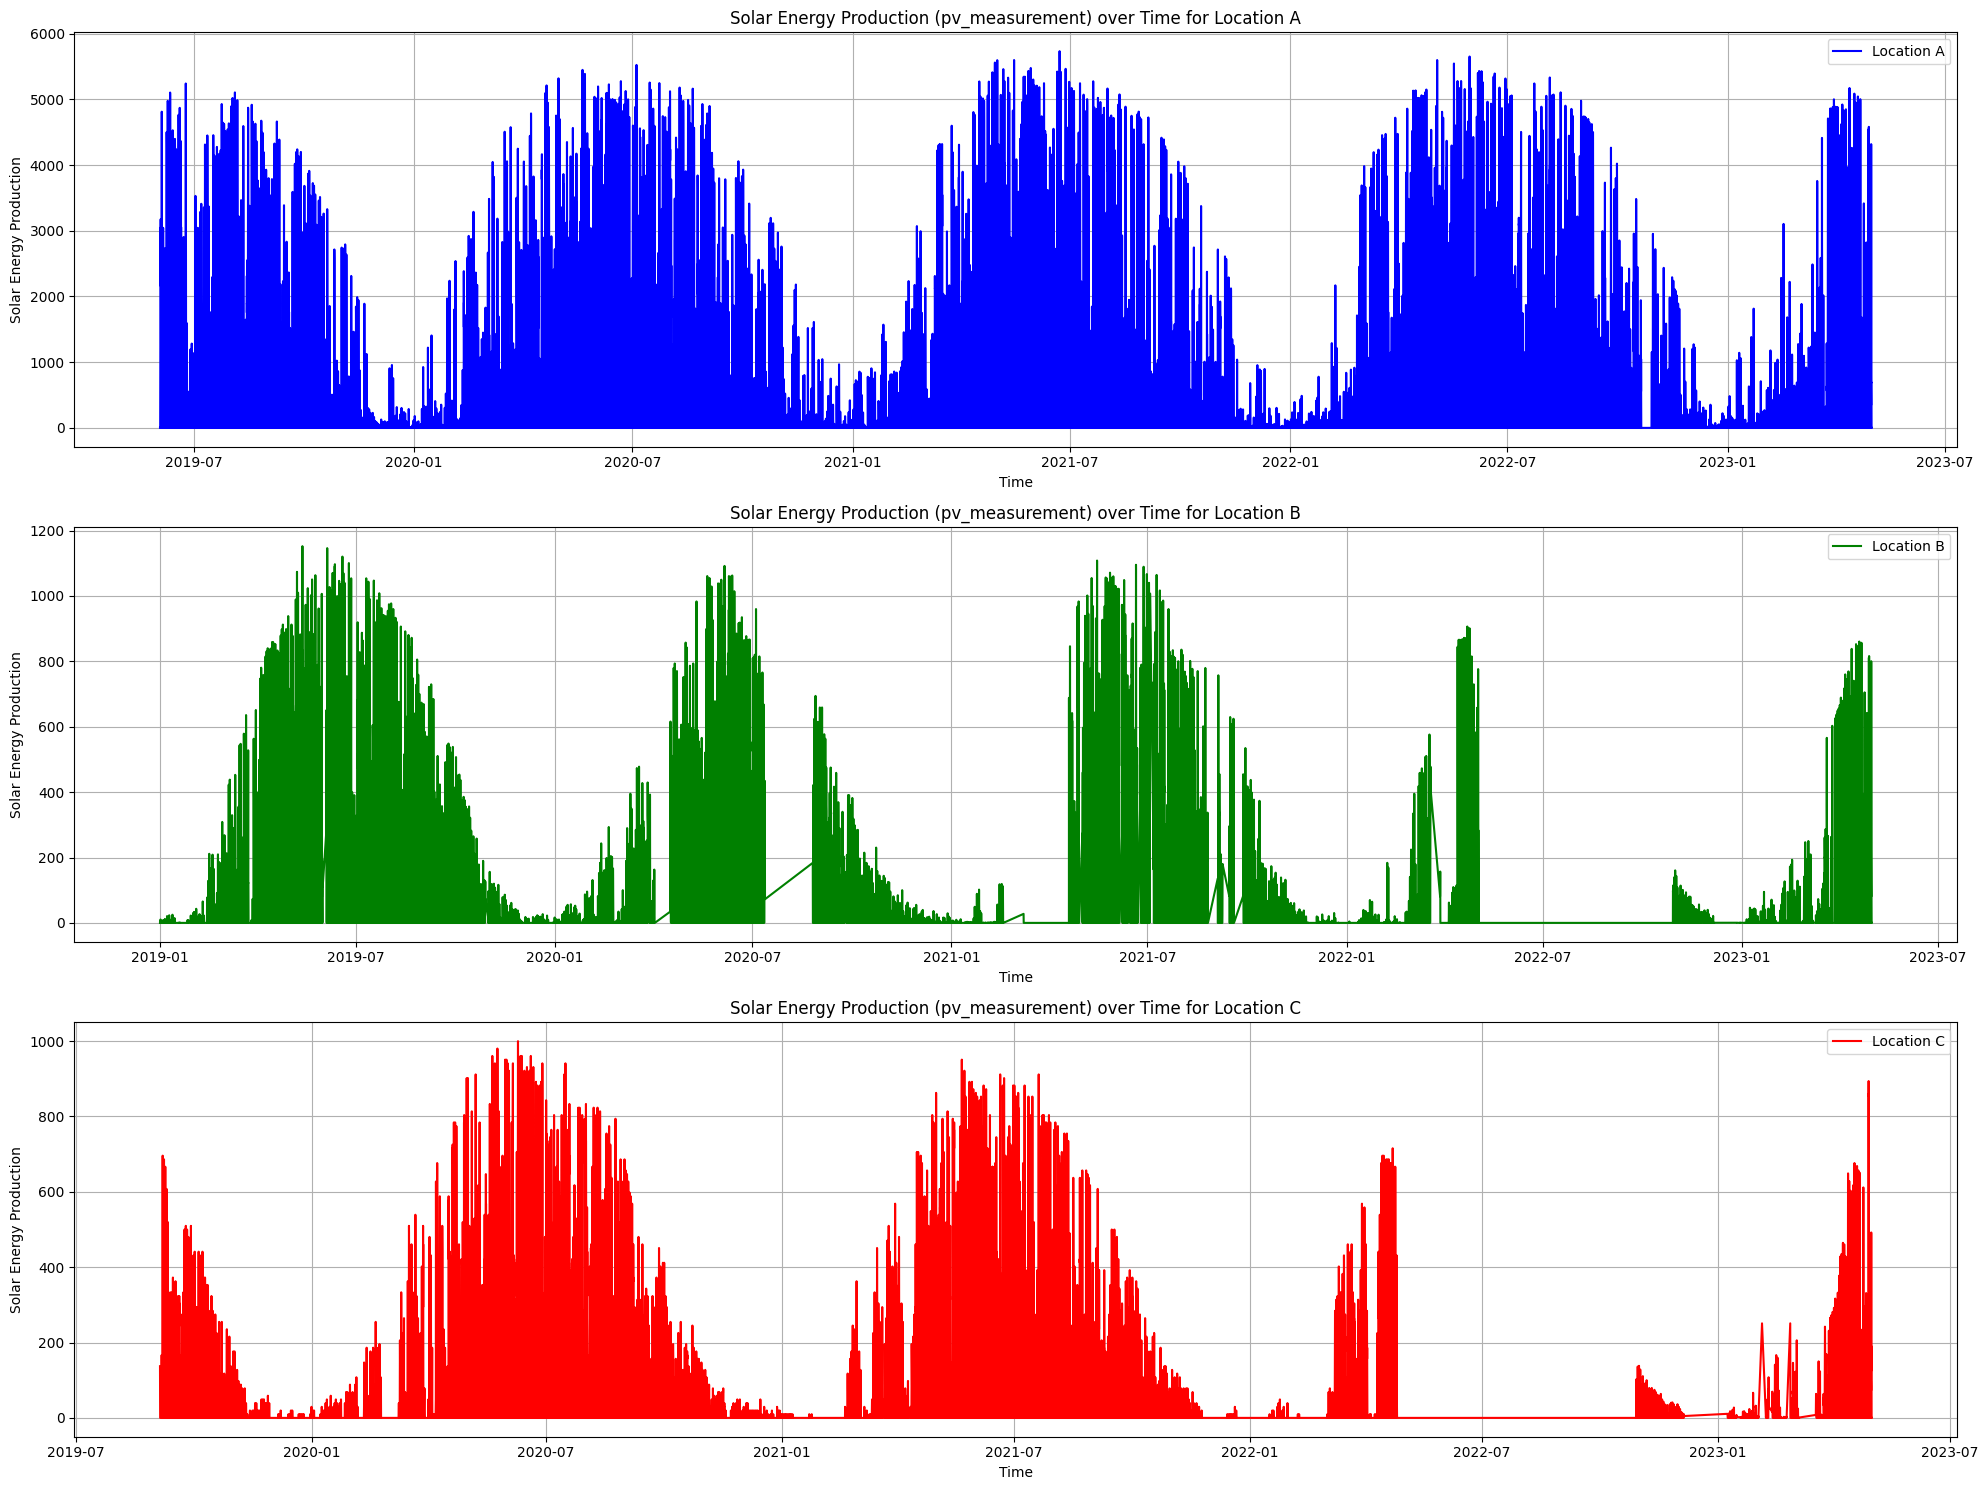

In [23]:
#exploratory data analysis and vizualization 

y_train_b = y_train_b.resample('1H').mean()
y_train_b.dropna(inplace=True)
#y_train_b.interpolate(method='time', inplace=True)

# Plotting the pv_measurement over time for locations A, B, and C
plt.figure(figsize=(20, 15))

# Location A
plt.subplot(3, 1, 1)
plt.plot(y_train_a['pv_measurement'], label='Location A', color='blue')
plt.title('Solar Energy Production (pv_measurement) over Time for Location A')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location B
plt.subplot(3, 1, 2)
plt.plot(y_train_b['pv_measurement'], label='Location B', color='green')
plt.title('Solar Energy Production (pv_measurement) over Time for Location B')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

# Location C
plt.subplot(3, 1, 3)
plt.plot(y_train_c['pv_measurement'], label='Location C', color='red')
plt.title('Solar Energy Production (pv_measurement) over Time for Location C')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_train_b.to_csv('b-test.csv')






In [4]:
#AutoTS 

model = AutoTS(forecast_length=14, frequency='infer', ensemble='simple', max_generations=10, num_validations=2)

model_a = model.fit(x_train_a, date_col='time', value_col='pv_measurement')

print(model_a)

Data frequency is: H, used frequency is: H
Model Number: 1 with model ARIMA in generation 0 of 10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32680D+00    |proj g|=  1.32795D+00


 This problem is unconstrained.



At iterate    1    f=  7.61531D+00    |proj g|=  2.07568D-01

At iterate    2    f=  7.54920D+00    |proj g|=  1.67807D-01

At iterate    3    f=  7.46117D+00    |proj g|=  6.59030D-02

At iterate    4    f=  7.43966D+00    |proj g|=  6.75071D-02

At iterate    5    f=  7.42487D+00    |proj g|=  6.40377D-02

At iterate    6    f=  7.39928D+00    |proj g|=  3.73819D-02

At iterate    7    f=  7.39770D+00    |proj g|=  2.40902D-02

At iterate    8    f=  7.39748D+00    |proj g|=  2.85418D-02

At iterate    9    f=  7.39629D+00    |proj g|=  1.22479D-02

At iterate   10    f=  7.39516D+00    |proj g|=  2.48253D-02

At iterate   11    f=  7.39173D+00    |proj g|=  3.07703D-02

At iterate   12    f=  7.39115D+00    |proj g|=  4.29701D-02

At iterate   13    f=  7.38933D+00    |proj g|=  3.52595D-02

At iterate   14    f=  7.38412D+00    |proj g|=  4.04927D-02

At iterate   15    f=  7.38148D+00    |proj g|=  3.49932D-02

At iterate   16    f=  7.37452D+00    |proj g|=  6.19056D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 10


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
1071/1071 [==============================] - 5s 2ms/step - loss: 0.1658
Epoch 2/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0912
Epoch 3/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0724
Epoch 4/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0671
Epoch 5/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0629
Epoch 6/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0604
Epoch 7/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0587
Epoch 8/50
1071/1071 [==============================] - 2s 2ms/step - loss: 0.0555
Epoch 9/50
1071/1071 [==============================] - 2s 1ms/step - loss: 0.0561
Epoch 10/50
1071/1071 [==============================] - 1s 1ms/step - loss: 0.0535
Epoch 11/50
1071/1071 [==============================] - 1s 1ms/step - loss: 0.0538
Epoch 12/50
1071/

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 36 with model FBProphet in generation 0 of 10
Template Eval Error: ModuleNotFoundError("No module named 'fbprophet'") in model 36 in generation 0: FBProphet
Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation is incompatible with AutoTS. The numpy version is sometimes the issue, try 1.23.1 {as of 06-2023}') in model 37 in generation 0: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10
Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39 in generation 0: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40 in generation 0: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10
Model Number: 42 w

 This problem is unconstrained.


Model Number: 60 with model UnivariateRegression in generation 0 of 10
Model Number: 61 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 61 in generation 0: ARCH
Model Number: 62 with model ConstantNaive in generation 0 of 10
Model Number: 63 with model LastValueNaive in generation 0 of 10
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 63 in generation 0: LastValueNaive
Model Number: 64 with model AverageValueNaive in generation 0 of 10
Model Number: 65 with model GLS in generation 0 of 10
Model Number: 66 with model SeasonalNaive in generation 0 of 10
Model Number: 67 with model GLM in generation 0 of 10


: 

In [29]:
#AutoML H2O

def train(model):
    if model.lower() == 'a':
        automl_df=x_train_a
    elif model.lower() == 'b':
        automl_df=x_train_b
    elif model.lower() == 'c':
        automl_df=x_train_c
    elif model.lower() == 's':
        automl_df=x_train
    else:
        return

    h2o.init()
    train_df = h2o.H2OFrame(automl_df)
    train_df.describe()

    test = h2o.H2OFrame(automl_df)
    x = test.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    from h2o.automl import H2OAutoML
    # callh20automl  function
    aml = H2OAutoML(max_runtime_secs = 120,
                    sort_metric='MAE',
                    stopping_metric='MAE',
                    stopping_tolerance=1e-3
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = test)

    # Obtain the leader model
    best_model = aml.leader

    # Save the leader model
    model_path = h2o.save_model(model=best_model, path="/tmp/mymodel", force=True)

    # Load the saved model
    loaded_model = h2o.load_model(model_path)

    # Download the model to local machine
    my_local_model = h2o.download_model(best_model, path=f"./models/{model.upper()}")

    h2o.cluster().shutdown()

    return my_local_model

 

In [79]:
my_local_model_all = train('s')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,10 mins 35 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_olelasson_40ccoo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.421 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:99014
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.5,1.1392500400543213,27.799999237060547,0.0,0.0,27.5,-1.0,247.4250030517578,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.375,0.0,0.0,929.9749755859376,935.75,0.0,0.0,19.575000762939453,941.5499877929688,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,258.0249938964844,0.0,132.375,0.02500000037252903,-7.224999904632568,-8.399999618530273,-0.10000000149011612,0.0,1.0,0.0
mean,6.047586706134849,1.2550115512246531,3150.95815076531,529168.55259402,146.99231393388376,1879.728883414517,0.004900822105964813,275.29335070501037,40.37591755433746,145348.23799427925,51.389801436288636,185001.93913569482,67.02690959432749,12.172490758882587,0.12394459354430375,0.010295261345900206,0.24545266308433802,0.030954208544325637,0.06195891488779988,0.48957723150261623,0.5595723837033141,1009.6110852936711,0.005677580937093536,0.08434665804835684,995.8209642762458,1001.9499131165958,0.8196606037290309,0.00956001188195547,73.57963797977101,1008.1061538220712,12.983012503282364,0.29524461236593735,2.7773850162603267e-05,0.0003448754695966531,0.08942977845800322,179.63003296478104,-0.7530374983665187,0.05752999680248639,279.51160815637314,73.63940479962187,33024.318089070344,3.0207137365094026,0.6687978472176545,0.6669773963931908,5.2265337050330715e-05,11.5013836427172,6.189629749328379,269.64400470525965
maxs,18.700000762939453,1.440999984741211,12294.9013671875,2990595.5,835.6500244140625,11673.724609375,1.0,294.92498779296875,334.75,1198315.125,683.4000244140625,2441810.5,100.0,24.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1044.0999755859375,0.6225000023841858,5.0,1030.875,1037.25,96.7750015258789,1.100000023841858,100.0,1043.7249755859375,250.0,25.950000762939453,1.0,0.18000000715255737,5.650000095367432,348.4875183105469,49.943748474121094,1.375,303.25,100.0,75489.328125,13.274999618530272,11.199999809265137,8.824999809265137,0.10000000149011612,23.0,12.0,5733.42
sigma,2.7443584542869255,0.03680622617412614,2700.2139158980335,829236.2297312977,230.9300000485744,1940.982139486639,0.2408068410074405,6.890142314322381,61.24571990454919,217873.58176530965,114.19930158912051,405798.14486005856,34.29876043661443,8.207947131465028,0.7899664780123267,0.10505205185477372,1.2579459086094131,0.2760061364976387,0.47963273725434635,0.4861534364742998,0.4837009649787938,13.000494402715718,0.028974547298651492,0.3292292006736318,12.910724537609802,12.967712546965453,5.565308714823626,0.0410049891122276,14.336951776339259,13.026894019003574,55.472746379208715,1.8089914848362818,0.004700243301439377,0.004805620004453144,0.23573185143093495,97.40514156283156,24.010154072864758,0.10653099562003665,6.5828165363446836,34.02867107551231,17852.905234400125,1.7497160893415225,2.7812799496436402,1.8766130696599523,0.00640475785609368,6.920768516443817,3.5448926846071114,746.0115031487045
zeros,0,0,0,43226,47363,0,91852,0,47382,43235,54774,49719,3645,0,92572,96927

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
H2O session _sid_9a99 closed.


In [30]:
my_local_model_A = train('a')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpqgnes88p
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpqgnes88p/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpqgnes88p/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_olelasson_fx1he9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:34061
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.699999988079071,1.1449999809265137,27.849998474121097,0.0,0.0,27.799999237060547,-1.0,251.0749969482422,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.4000244140624,0.0,0.0,932.4000244140624,938.2000122070312,0.0,0.0,21.700000762939453,944.0,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.89399719238281,0.0,259.0,0.0,159.6750030517578,0.02500000037252903,-7.224999904632568,-8.399999618530273,0.0,0.0,1.0,0.0
mean,6.322320250351401,1.2532797771004038,3300.501445790256,552671.1678821972,153.51968819845212,1872.8618892791128,0.020668800093949093,275.97182254114244,42.06996638320775,151451.71881457855,52.62769958820423,189459.87623030285,67.70161258036258,6.0,0.08820278320963196,0.007402894869658933,0.17359516759169832,0.02228942194988068,0.04440489122286148,0.4991852852235699,0.5353483456152195,1009.603843063803,0.006014650169552615,0.0890754822230704,996.7075658886545,1002.8290874581662,0.23188544087143018,0.0107828603490834,74.02536330787697,1008.9778176316054,8.367340947124276,0.07350855843764993,0.0,0.00012727165757659995,0.0896883540659685,179.63674567712494,-0.04687209569277345,0.05566483764321577,279.9364118813764,74.31900637064247,32577.394217938363,3.061313524594808,0.6572061894577825,0.5701616212857115,1.6881477601014875e-05,11.500954170458902,6.541499075188637,631.0111649687328
maxs,17.350000381469727,1.4262499809265137,12294.9013671875,2988627.5,835.0999755859375,11673.625,1.0,293.625,332.2749938964844,1191085.25,683.4000244140625,2441749.5,100.0,6.0,15.0,3.549999952316284,15.0,7.875,14.225000381469728,1.0,1.0,1043.949951171875,0.6225000023841858,3.75,1030.875,1037.25,91.875,1.100000023841858,100.0,1043.7249755859375,250.0,6.300000190734863,0.0,0.13249999284744263,5.650000095367432,348.48651123046875,49.90550231933594,1.2999999523162842,303.25,100.0,69395.5234375,13.274999618530272,11.199999809265137,8.25,0.10000000149011612,23.0,12.0,5733.42
sigma,2.799442323741874,0.03720644592716358,2745.4958027370953,848338.9524549864,236.24473088072932,1968.5202884119785,0.1852969847046359,6.892324036977613,62.8385233773589,223524.79904018878,115.25055669696049,409345.4349368961,33.808253285702605,0.0,0.5945263496675198,0.08363566233487284,0.9281759804668741,0.2141134034093852,0.3667132677670624,0.4861571690937141,0.48665592243719435,12.739137877864016,0.030217786318958405,0.3236889172912679,12.603231746387415,12.659498234019072,2.80325699589278,0.043944979795541676,13.881200569168275,12.717940639972545,44.96534446525811,0.46848760865667327,0.0,0.0026485422313329014,0.2375475612408994,97.65791732299918,24.15515029849285,0.1039186668394868,6.664930199350173,33.49235436406495,17701.938312145772,1.774981540205253,2.8897352083282946,1.8371422374293822,0.0011572652695004493,6.9230889682910455,3.4791071364276323,1166.2060656312103
zeros,0,0,0,14533,15958,0,32520,0,15966,14536,18178,16399,1091,0,32398,33532,31467,33268,32948,15952,14819,0,30325,30325,0,0,33463,30968,0,0,32921,32921,34061

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:27:50.929: Stopping tolerance set by the user is < 70% of the recommended default of 0.005418402997428423, so models may take a long time to converge or may not converge at all.
17:27:51.37: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████████████
17:28:18.726: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
17:28:22.9: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████████████
17:28:45.456: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]
17:28:46.137: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████
17:28:55.804: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
17:29:06.205: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
17:29:15.39

In [31]:
my_local_model_B = train('b')


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp85lr5_7m
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp85lr5_7m/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp85lr5_7m/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_olelasson_wwrnwa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:32819
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.699999988079071,1.1514999866485596,27.849998474121097,0.0,0.0,27.975000381469727,-1.0,251.0500030517578,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.5,0.0,0.0,932.2999877929688,938.0499877929688,0.0,0.0,19.575000762939453,943.8499755859376,0.0,0.0,0.0,0.0,0.0,6.983749866485596,-49.89324951171875,0.0,259.0249938964844,0.0,174.72500610351562,0.05000000074505806,-7.224999904632568,-8.399999618530273,0.0,0.0,1.0,0.0
mean,5.934880709305968,1.256660272966208,3059.3041495553316,512965.1494978501,142.49626433924374,1865.3298177122515,0.009110576190621285,275.06237850295605,39.266121754284015,141344.85332452905,50.76235716004591,182738.91441975426,66.93957692772317,7.0,0.09081172482388794,0.00741643565190863,0.18057680011545685,0.022419177891008973,0.04514001031873915,0.48287577318016967,0.5518982906243345,1009.5595386279269,0.005440903124607917,0.07980133459276641,996.5048783174833,1002.642297830823,0.06110408564452812,0.008982601697207937,73.23997759109268,1008.8071316121872,12.233767025198818,0.3151627112833358,6.0940308967366465e-05,0.0002798683674728896,0.08951826768318379,179.62100381773337,-1.2410771661935787,0.05691291733776211,279.1958971767755,73.51475822997295,33167.87828965244,3.1353552813401278,0.6693119842708034,0.5728655650180147,2.437612400693422e-05,11.499558182760005,5.96559919558792,96.89333532059365
maxs,17.350000381469727,1.4254999160766602,12285.775390625,2988610.25,835.0999755859375,11673.724609375,1.0,293.6000061035156,332.2749938964844,1190978.0,683.4000244140625,2441810.5,100.0,7.0,12.25,3.125,14.975000381469728,7.875,12.25,1.0,1.0,1044.0999755859375,0.5849999785423279,3.75,1030.7249755859375,1037.14990234375,73.0999984741211,0.8999999761581421,100.0,1043.5999755859375,250.0,18.200000762939453,1.0,0.18000000715255737,3.549999952316284,348.4875183105469,49.90550231933594,1.2999999523162842,303.25,100.0,68500.0,13.274999618530272,11.199999809265137,8.225000381469727,0.10000000149011612,23.0,12.0,1152.3
sigma,2.673430616555042,0.035018019307795294,2651.6913705185893,815891.0426390163,227.21488527435886,1885.3640872096166,0.11438667574823529,6.704737773898367,60.15292217763055,214003.08931227386,113.64595166072736,403967.726599394,34.163777001711566,0.0,0.5939540835664405,0.07638852985191924,0.9934223991260627,0.19946748629125208,0.34778464314241697,0.4860359199578583,0.48484849064959296,13.149583638655498,0.028180487561773434,0.3248581169831406,13.030123297933114,13.088125543705583,1.2439491894207284,0.03934498611252257,14.296537407059343,13.14818802310706,53.93389782176854,1.8227784088205947,0.00703646189123479,0.004679223335488311,0.23448712011628225,97.239392437306,23.90685143145078,0.10547396272422568,6.516826092345266,33.90732365963281,17828.82419803574,1.823091926813074,2.9773496843050458,1.8643682895255178,0.001407134053763868,6.919702478691892,3.570589030381934,194.00408511822394
zeros,0,0,0,14551,15923,0,32232,0,15927,14553,17961,16301,1210,0,31

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:30:38.711: Stopping tolerance set by the user is < 70% of the recommended default of 0.005519977761158394, so models may take a long time to converge or may not converge at all.
17:30:38.832: _train param, Dropping bad and constant columns: [elevation:m]

███████████████
17:31:08.462: _train param, Dropping bad and constant columns: [elevation:m]

██
17:31:11.416: _train param, Dropping bad and constant columns: [elevation:m]

█████████████████████████
17:31:59.815: _train param, Dropping unused columns: [elevation:m]

█
17:32:00.782: _train param, Dropping bad and constant columns: [elevation:m]

███
17:32:06.602: _train param, Dropping bad and constant columns: [elevation:m]

███
17:32:12.752: _train param, Dropping bad and constant columns: [elevation:m]

███
17:32:18.371: _train param, Dropping bad and constant columns: [elevation:m]

███
17:32:24.760: _train param, 

In [32]:
my_local_model_C = train('c')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpzun8n3py
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpzun8n3py/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmpzun8n3py/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_olelasson_8ey9c4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:26071
Cols:48

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,hour,month,pv_measurement
type,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real
mins,0.5,1.1392500400543213,27.799999237060547,0.0,0.0,27.5,-1.0,247.4250030517578,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.375,0.0,0.0,929.9749755859376,935.75,0.0,0.0,21.325000762939453,941.5499877929688,0.0,0.0,0.0,0.0,0.0,6.982999801635742,-49.93199920654297,0.0,258.0249938964844,0.0,132.375,0.05000000074505806,-6.300000190734863,-7.875,-0.10000000149011612,0.0,1.0,0.0
mean,5.722883666086602,1.2567093703621601,3404.4670953500085,468898.71562432405,130.2399054104814,1954.157649874645,-0.014230370910206748,274.5002101570283,36.06318612559717,129829.25709932971,46.48144966129935,167351.6100910867,66.46761153481192,24.0,0.1879319931011044,0.015671627548223925,0.37163898457333294,0.0469209083751519,0.093850446849459,0.4630911741014919,0.6176786467722739,1009.2982807259664,0.005463062403263137,0.08389589965862433,993.7940950313582,999.9285739542979,2.286363201726625,0.00871082828036695,73.74915233098613,1006.0903922399916,14.067354531855319,0.1959159604912564,0.0,0.000455678719784295,0.09207932276677759,179.69871617812024,-2.6793301073611726,0.05848835974347016,279.0654518636922,73.09790765526745,33429.97046845481,2.8855835971933335,0.6682022170628672,0.9765294759596538,-8.150819081894985e-05,11.504084998657541,6.385907713551449,77.70004295961023
maxs,15.925000190734863,1.440999984741211,12260.224609375,2990595.5,835.6500244140625,11652.7001953125,1.0,292.07501220703125,334.75,1198315.125,682.3250122070312,2437657.75,100.0,24.0,37.474998474121094,7.25,37.474998474121094,20.325000762939453,33.375,1.0,1.0,1043.9000244140625,0.6075000166893005,5.0,1028.300048828125,1034.64990234375,96.7750015258789,0.699999988079071,100.0,1041.0999755859375,250.0,11.600000381469728,0.0,0.17000000178813934,3.549999952316284,348.47698974609375,49.943748474121094,1.375,302.8999938964844,100.0,75489.328125,12.425000190734863,10.024999618530272,8.824999809265137,0.10000000149011612,23.0,12.0,999.6
sigma,2.601514779865329,0.037491326103715535,2846.741564377102,778982.7846718436,216.94344716246832,2112.8000910810783,0.3661761652282859,6.808953245649311,57.653805681880534,205090.80404194945,108.74699457598064,386574.30347950367,34.98187889076979,0.0,1.1202722690710192,0.15077158503051177,1.7139922226550919,0.39953174102110023,0.6940313407192433,0.484915218143419,0.47207549277066924,13.444906427240007,0.02899467302322099,0.34445501801403167,13.267859637279914,13.3329098973091,9.196404856639903,0.03942214090356106,14.57513926657047,13.400135937862347,57.61141795283577,1.0484518712839264,0.0,0.005251258924785615,0.24237355893390222,96.84819701223603,23.72683521515741,0.10857182782949919,6.27127707622063,34.83087117372844,18280.653624025148,1.646769095118115,2.433864248531301,1.9189721818054446,0.011129536669052763,6.9171471171586285,3.708305519144869,165.87752120814113
zeros,0,0,0,12079,13166,0,21821,0,13174,12083,15783,14482,1080,0,23711,25350,22456,24969,24510,13165,9134,0,23821,23821,0,0,23151,24169,

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
17:32:57.666: Stopping tolerance set by the user is < 70% of the recommended default of 0.006193286276785341, so models may take a long time to converge or may not converge at all.
17:32:57.893: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███████████████
17:33:27.742: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
17:33:30.732: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████████████████
17:34:04.704: _train param, Dropping unused columns: [snow_drift:idx, elevation:m]
17:34:05.641: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████
17:34:13.509: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
17:34:21.708: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
17:34

In [33]:

h2o.init()
model_a = h2o.upload_model(my_local_model_A)
#model = h2o.get_model(model_a)


x_test_a = preprocessing_X(X_test_estimated_a)

est_test_a = h2o.H2OFrame(x_test_a)
preds_a = model_a.predict(est_test_a)
preds_df_a = preds_a.as_data_frame()


model_b = h2o.upload_model(my_local_model_B)
#model = h2o.get_model(model_b)

x_test_b = preprocessing_X(X_test_estimated_b)

est_test_b = h2o.H2OFrame(x_test_b)
preds_b = model_b.predict(est_test_b)
preds_df_b = preds_b.as_data_frame()


model_c = h2o.upload_model(my_local_model_C)
#model = h2o.get_model(model_c)

x_test_c = preprocessing_X(X_test_estimated_c)

est_test_c = h2o.H2OFrame(x_test_c)
preds_c = model_c.predict(est_test_c)
preds_df_c = preds_c.as_data_frame()





Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_321"; Java(TM) SE Runtime Environment (build 1.8.0_321-b07); Java HotSpot(TM) 64-Bit Server VM (build 25.321-b07, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp5d7jtzy5
  JVM stdout: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp5d7jtzy5/h2o_olelasson_started_from_python.out
  JVM stderr: /var/folders/1q/8rdw88jx5gbg17r7l_hz847h0000gn/T/tmp5d7jtzy5/h2o_olelasson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_olelasson_1onesu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.769 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [34]:
final_df = pd.concat([preds_df_a, preds_df_b, preds_df_c], axis=0, ignore_index=True)
final_df.index.name = 'id'
final_df.rename(columns={'predict': 'prediction'}, inplace=True)
print(len(preds_df_a))

print(len(preds_df_b))
print(len(preds_df_c))


final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 0 else x)
final_df.to_csv('predictions_v14.csv')

preds_df_a.head()

720
720
720


,predict
0,-3.098872
1,-3.098872
2,-2.892370
3,57.927501
4,351.517907
